<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Parcel-model-with-30-aerosol-masses,-lognormal-distribution" data-toc-modified-id="Parcel-model-with-30-aerosol-masses,-lognormal-distribution-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Parcel model with 30 aerosol masses, lognormal distribution</a></span><ul class="toc-item"><li><span><a href="#Read-in-the-json-file-and-set-the-koehler-function-for-this-aerosol" data-toc-modified-id="Read-in-the-json-file-and-set-the-koehler-function-for-this-aerosol-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Read in the json file and set the koehler function for this aerosol</a></span></li><li><span><a href="#initialize-the-lognormal-mass-and-number-distributions-for-30-bins" data-toc-modified-id="initialize-the-lognormal-mass-and-number-distributions-for-30-bins-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>initialize the lognormal mass and number distributions for 30 bins</a></span></li><li><span><a href="#find-the-equilibrium-radius-for-each-bin-at-saturation-Sinit" data-toc-modified-id="find-the-equilibrium-radius-for-each-bin-at-saturation-Sinit-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>find the equilibrium radius for each bin at saturation Sinit</a></span></li><li><span><a href="#now-add-the-intial-conditions-to-the-cloud_vars-dictionary-and-make-it-a-namedtuple" data-toc-modified-id="now-add-the-intial-conditions-to-the-cloud_vars-dictionary-and-make-it-a-namedtuple-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>now add the intial conditions to the cloud_vars dictionary and make it a namedtuple</a></span></li><li><span><a href="#use-odeint-to-integrate-the-variable-in-var_vec-from-tinit-to-tfin-with-outputs-every-dt-seconds" data-toc-modified-id="use-odeint-to-integrate-the-variable-in-var_vec-from-tinit-to-tfin-with-outputs-every-dt-seconds-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>use odeint to integrate the variable in var_vec from tinit to tfin with outputs every dt seconds</a></span></li><li><span><a href="#create-a-dataframe-with-33-columns-to-hold-the-data" data-toc-modified-id="create-a-dataframe-with-33-columns-to-hold-the-data-1.6"><span class="toc-item-num">1.6&nbsp;&nbsp;</span>create a dataframe with 33 columns to hold the data</a></span></li><li><span><a href="#store-the-dataframe-in-an-csv-file,-including-a-copy-of-the-input-dictionary-for-future-reference" data-toc-modified-id="store-the-dataframe-in-an-csv-file,-including-a-copy-of-the-input-dictionary-for-future-reference-1.7"><span class="toc-item-num">1.7&nbsp;&nbsp;</span>store the dataframe in an csv file, including a copy of the input dictionary for future reference</a></span></li><li><span><a href="#Matt's-solution" data-toc-modified-id="Matt's-solution-1.8"><span class="toc-item-num">1.8&nbsp;&nbsp;</span>Matt's solution</a></span><ul class="toc-item"><li><span><a href="#do-test-at-z-=-1010-meters" data-toc-modified-id="do-test-at-z-=-1010-meters-1.8.1"><span class="toc-item-num">1.8.1&nbsp;&nbsp;</span>do test at z = 1010 meters</a></span></li><li><span><a href="#find-the-differentials" data-toc-modified-id="find-the-differentials-1.8.2"><span class="toc-item-num">1.8.2&nbsp;&nbsp;</span>find the differentials</a></span></li><li><span><a href="#write-everything-out-as-a-tuple" data-toc-modified-id="write-everything-out-as-a-tuple-1.8.3"><span class="toc-item-num">1.8.3&nbsp;&nbsp;</span>write everything out as a tuple</a></span></li><li><span><a href="#return-$\Delta-SS$-given-the-tuple-t" data-toc-modified-id="return-$\Delta-SS$-given-the-tuple-t-1.8.4"><span class="toc-item-num">1.8.4&nbsp;&nbsp;</span>return $\Delta SS$ given the tuple t</a></span></li><li><span><a href="#Check-against-the-output-$\Delta-SS$" data-toc-modified-id="Check-against-the-output-$\Delta-SS$-1.8.5"><span class="toc-item-num">1.8.5&nbsp;&nbsp;</span>Check against the output $\Delta SS$</a></span></li></ul></li></ul></li><li><span><a href="#Now-redo-with-interactive-SS-as-variable-4" data-toc-modified-id="Now-redo-with-interactive-SS-as-variable-4-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Now redo with interactive SS as variable 4</a></span></li></ul></div>

# Parcel model with 30 aerosol masses, lognormal distribution

In [1]:
import json
import a405.utils
from pathlib import Path
import numpy as np
from a405.dropgrow.aerolib import lognormal,create_koehler
from a405.utils.helper_funs import make_tuple, find_centers
from collections import OrderedDict as od
from a405.thermo.thermlib import find_esat
from a405.thermo.rootfinder import find_interval, fzero
from a405.dropgrow.drop_grow import find_diff, rlcalc, find_derivs, Scalc, rlderiv
from a405.thermo.constants import constants as c
from scipy.integrate import odeint
import pandas as pd
from matplotlib import pyplot as plt
import datetime
import importlib_resources as ir 
import pprint
pp = pprint.PrettyPrinter(indent=4)

## Read in the json file and set the koehler function for this aerosol

In [2]:
with ir.open_text('a405.data','dropgrow.json') as f:
    input_dict=json.load(f)
pp.pprint(input_dict)

aero=make_tuple(input_dict['aerosol'])
parcel=make_tuple(input_dict['initial_conditions'])

koehler_fun = create_koehler(aero,parcel)
    

{   'aerosol': {   'Ms': 114,
                   'Mw': 18.0,
                   'Sigma': 0.075,
                   'rhoaero': 1775,
                   'sd': 1.7,
                   'themean': 2e-17,
                   'totmass': 1.5e-09,
                   'vanHoff': 2.0},
    'dir_name': 'dump_run',
    'dump_output': True,
    'initial_conditions': {   'Pinit': 90000.0,
                              'Sinit': 0.995,
                              'Tinit': 280.0,
                              'Zinit': 1000.0,
                              'wvel': 0.5},
    'integration': {'dt': 1, 'tend': 200, 'tstart': 0},
    'output_file': 'outfile'}


## initialize the lognormal mass and number distributions for 30 bins

In [3]:
#
#set the edges of the mass bins
#31 edges means we have 30 droplet bins
#
numrads = 30
mass_vals = np.linspace(-20,-16,numrads+1) 
mass_vals = 10**mass_vals  #aerosol mass in kg
mu=input_dict['aerosol']['themean']
sigma = input_dict['aerosol']['sd']
totmass = input_dict['aerosol']['totmass']
mdist = totmass*lognormal(mass_vals,np.log(mu),np.log(sigma))
mdist = find_centers(mdist)*np.diff(mass_vals)  #kg/m^3 of aerosol in each bin
center_mass = find_centers(mass_vals)
ndist = mdist/center_mass  #number/m^3 of aerosol in each bin
#save these in an ordered dictionary to pass to functions
cloud_vars = od()
cloud_vars['mdist'] = mdist
cloud_vars['ndist'] = ndist
cloud_vars['center_mass'] = center_mass
cloud_vars['koehler_fun'] = koehler_fun

## find the equilibrium radius for each bin at saturation Sinit

In [4]:
S_target = parcel.Sinit
logr_start = np.log(0.1e-6)

initial_radius = []
dry_radius = []
for mass in center_mass:
    brackets = np.array(find_interval(find_diff,logr_start,S_target,mass,koehler_fun))
    left_bracket, right_bracket = np.exp(brackets)*1.e6  #get brackets in microns for printing
    equil_rad = np.exp(fzero(find_diff,brackets,S_target,mass,koehler_fun))

    initial_radius.append(equil_rad)
    dry_rad = (mass/(4./3.*np.pi*aero.rhoaero))**(1./3.)
    dry_radius.append(dry_rad)

    print('mass = {mass:6.3g} kg'.format_map(locals()))
    print('equlibrium radius at S={} is {:5.3f} microns\n'.format(S_target,equil_rad*1.e6))

mass = 1.18e-20 kg
equlibrium radius at S=0.995 is 0.026 microns

mass = 1.6e-20 kg
equlibrium radius at S=0.995 is 0.030 microns

mass = 2.18e-20 kg
equlibrium radius at S=0.995 is 0.035 microns

mass = 2.96e-20 kg
equlibrium radius at S=0.995 is 0.040 microns

mass = 4.03e-20 kg
equlibrium radius at S=0.995 is 0.046 microns

mass = 5.48e-20 kg
equlibrium radius at S=0.995 is 0.053 microns

mass = 7.44e-20 kg
equlibrium radius at S=0.995 is 0.061 microns

mass = 1.01e-19 kg
equlibrium radius at S=0.995 is 0.071 microns

mass = 1.38e-19 kg
equlibrium radius at S=0.995 is 0.081 microns

mass = 1.87e-19 kg
equlibrium radius at S=0.995 is 0.093 microns

mass = 2.54e-19 kg
equlibrium radius at S=0.995 is 0.106 microns

mass = 3.45e-19 kg
equlibrium radius at S=0.995 is 0.121 microns

mass = 4.7e-19 kg
equlibrium radius at S=0.995 is 0.138 microns

mass = 6.38e-19 kg
equlibrium radius at S=0.995 is 0.157 microns

mass = 8.68e-19 kg
equlibrium radius at S=0.995 is 0.178 microns

mass = 1.18e

## now add the intial conditions to the cloud_vars dictionary and make it a namedtuple

the vector var_vec holds 30 droplet radii plus three extra variables at the
end of the vector: the temperature, pressure and height.

In [5]:
cloud_vars['initial_radiius'] = initial_radius
cloud_vars['dry_radius'] = dry_radius
cloud_vars['masses'] = center_mass
numrads = len(initial_radius)
var_vec = np.empty(numrads + 3)
for i in range(numrads):
    var_vec[i] = initial_radius[i]

#
# temp, press and height go at the end of the vector
#
var_vec[-3] = parcel.Tinit
var_vec[-2] = parcel.Pinit
var_vec[-1] = parcel.Zinit

cloud_tup = make_tuple(cloud_vars)
#calculate the total water (kg/kg)
rl=rlcalc(var_vec,cloud_tup);
e=parcel.Sinit*find_esat(parcel.Tinit);
rv=c.eps*e/(parcel.Pinit - e)
#save total water
cloud_vars['rt'] = rv + rl
cloud_vars['wvel'] = parcel.wvel
wvel_init=8.
cloud_vars['wvel'] = wvel_init
#
# pass this to the find_derivs function
#
cloud_tup= make_tuple(cloud_vars)



## use odeint to integrate the variable in var_vec from tinit to tfin with outputs every dt seconds

In [6]:
var_out = []
time_out =[]

tinit=input_dict['integration']['dt']
dt = input_dict['integration']['dt']
tfin = input_dict['integration']['tend']

t = np.arange(0,tfin,dt)
sol = odeint(find_derivs,var_vec, t, args=(cloud_tup,))

## create a dataframe with 33 columns to hold the data

In [7]:
colnames = ["r{}".format(item) for item in range(30)]
colnames.extend(['temp','press','z'])
df_output = pd.DataFrame.from_records(sol,columns = colnames)

## store the dataframe in an csv file, including a copy of the input dictionary for future reference

In [8]:
if input_dict['dump_output']:
    outfile_name = f'{input_dict["output_file"]}.csv'
    with open(outfile_name,'w') as store:
       df_output.to_csv(store)

    metadata_name = f'{input_dict["output_file"]}.json'
    date=datetime.datetime.now().strftime('%Y-%M-%d')
    with open(metadata_name,'w') as meta:
        history ="file produced by drop_grow.py on {}".format(date)
        print('history: ',history)
        input_dict['history']=history
        json.dump(input_dict,meta,indent=4)


history:  file produced by drop_grow.py on 2018-23-25


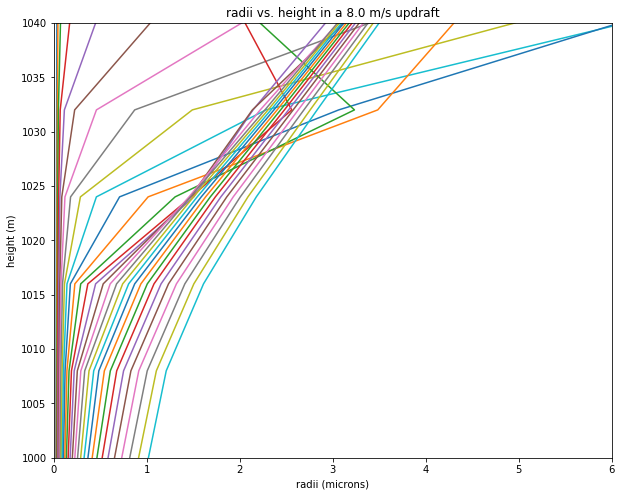

In [9]:
fig, ax = plt.subplots(1,1,figsize=[10,8])
for i in colnames[:-3]:
    ax.plot(df_output[i]*1.e6,df_output['z'],label=i)
out=ax.set(ylim=[1000,1040],xlim=[0,6],
       xlabel='radii (microns)',ylabel='height (m)',
              title='radii vs. height in a {} m/s updraft'.format(cloud_tup.wvel))

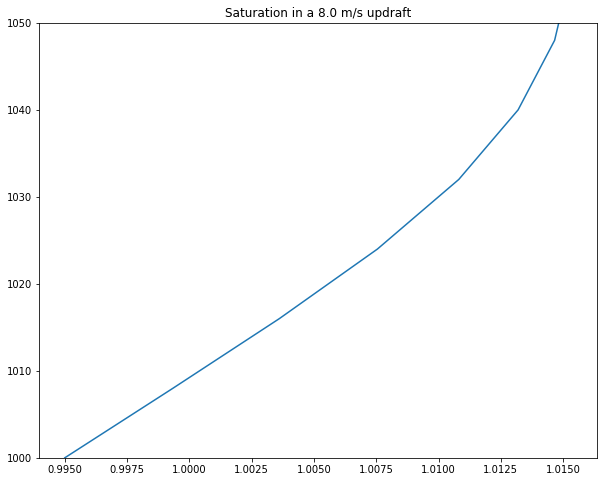

In [10]:
Svals = []
for index,row in df_output.iterrows():
    var_vec = row.values
    Svals.append(Scalc(var_vec,cloud_tup))
fig,ax = plt.subplots(1,1,figsize=[10,8])
ax.plot(Svals,df_output['z'])
out=ax.set(ylim=[1000,1050],title=f'Saturation in a {cloud_tup.wvel} m/s updraft')


$$
\frac{d r_v}{dt} = \left (1 + SS \right )  \left [ \frac{-\epsilon e_s}{p^2} 
\left ( \frac{-g p V}{R_d T} \right ) + \frac{\epsilon}{p} \left ( 
\frac{\epsilon e_s L}{R_d T^2} \right ) \frac{dT}{dt} \right ]
+ \frac{\epsilon e_s}{p} \frac{dSS}{dt}
$$

## Matt's solution

Below Matt computes the differential $\Delta SS$, estimating $\Delta r_v$, $\Delta T$ from the
output.

In [11]:
df_output.columns
# get index corresponding to 1010

Index(['r0', 'r1', 'r2', 'r3', 'r4', 'r5', 'r6', 'r7', 'r8', 'r9', 'r10',
       'r11', 'r12', 'r13', 'r14', 'r15', 'r16', 'r17', 'r18', 'r19', 'r20',
       'r21', 'r22', 'r23', 'r24', 'r25', 'r26', 'r27', 'r28', 'r29', 'temp',
       'press', 'z'],
      dtype='object')

### do test at z = 1010 meters

In [12]:
z = 1010
ind = np.searchsorted(df_output['z'].values,z)

### find the differentials

In [13]:
# since I need differential, find relevant diff & centered averages
dT = np.diff(df_output['temp'][ind-1:ind+1].values)
dSS = np.diff(Svals[ind-1:ind+1])

center_avg = lambda vec: (vec[:-1] + vec[1:]) / 2.
T_array = df_output['temp'][ind-1:ind+1].values
p_array = df_output['press'][ind-1:ind+1].values
es_array = np.array([find_esat(t) for t in T_array])
rv_array = c.eps * es_array / (p_array - es_array)

d_rv = np.diff(rv_array)

### write everything out as a tuple

In [14]:
from a405.thermo.thermlib import find_lv
T_1010 = df_output['temp'][ind]
p_1010 = df_output['press'][ind]
es_1010 = find_esat(T_1010)
drv_1010 = d_rv[0]
dT_1010 = dT[0]
Lv_1010 = find_lv(T_1010)
v_1010 = cloud_tup.wvel
SS_1010 = Svals[ind]

dSS_dict = {}
dSS_dict['T'] = T_1010
dSS_dict['p'] = p_1010
dSS_dict['es'] = es_1010
dSS_dict['drv'] = drv_1010
dSS_dict['dT'] = dT_1010
dSS_dict['Lv'] = Lv_1010
dSS_dict['v'] = v_1010
dSS_dict['SS'] = SS_1010

dSS_tup = make_tuple(dSS_dict)

### return $\Delta SS$ given the tuple t

In [15]:
def find_dSS(t):
    """
    Find ΔSS given a tuple of parameter values
    """
    dp_dt = -c.g0 * t.p * t.v / (c.Rd * t.T)
    des_dT = c.eps * t.Lv * t.es / (c.Rd * (t.T ** 2))
    bracket = (-c.eps * t.es / (t.p ** 2)) * dp_dt + (c.eps / t.p) * des_dT * t.dT
    divide = c.eps * t.es / t.p
    dSS = (t.drv - (1+t.SS) * bracket ) / divide
    return dSS


### Check against the output $\Delta SS$

In [16]:
dSS = np.diff(Svals)
dSS_1010 = dSS[ind-1]
dSS_calc = find_dSS(dSS_tup)
print(f'Calculated ΔSS: {dSS_calc:.2e} -- ΔSS from figure: {dSS_1010:.2e}')

Calculated ΔSS: 4.37e-03 -- ΔSS from figure: 4.27e-03


#  Now redo with interactive SS as variable 4

In [17]:
cloud_vars['initial_radiius'] = initial_radius
cloud_vars['dry_radius'] = dry_radius
cloud_vars['masses'] = center_mass
numrads = len(initial_radius)
nvars = 4   # SS, temp, press, height
var_vec = np.empty(numrads + nvars)
for i in range(numrads):
    var_vec[i] = initial_radius[i]

#
# temp, press and height go at the end of the vector
#
var_vec[-4] = parcel.Sinit - 1
var_vec[-3] = parcel.Tinit
var_vec[-2] = parcel.Pinit
var_vec[-1] = parcel.Zinit

cloud_tup = make_tuple(cloud_vars)
#calculate the total water (kg/kg)
rl=rlcalc(var_vec,cloud_tup,nvars=4);
e=parcel.Sinit*find_esat(parcel.Tinit);
rv=c.eps*e/(parcel.Pinit - e)
#save total water
cloud_vars['rt'] = rv + rl
cloud_vars['wvel'] = parcel.wvel
cloud_vars['wvel'] = wvel_init
#
# pass this to the find_derivs function
#
cloud_tup= make_tuple(cloud_vars)



In [18]:

def find_dSSdt(t):
    """
    Find dSS/dt given a tuple of parameter values
    """
    dp_dt = -c.g0 * t.p * t.v / (c.Rd * t.T)
    des_dT = c.eps * t.Lv * t.es / (c.Rd * (t.T ** 2))
    bracket = (-c.eps * t.es / (t.p ** 2)) * dp_dt + (c.eps / t.p) * des_dT * t.dTdt
    divide = c.eps * t.es / t.p
    dSSdt = (t.drvdt - (1+t.SS) * bracket ) / divide
    return dSSdt

def find_derivs(var_vec,the_time,cloud_tup,nvars=4):
    """
    calcuate derivatives of var_vec 

    Parameters
    ----------

    var_vec: vector(float)
        vector of values to be integrated

    the_time: float
       timestep 

    cloud_tup: namedtuple
           tuple of necessary coefficients
    

    Returns
    -------

    deriv_vec: vector(float)
         derivatives of each of var_vec
    
    """
    #print('inside: ',var_vec)
    temp,press,height = var_vec[-3:]
    numrads = len(var_vec) - nvars
    dry_radius = cloud_tup.dry_radius
    rho=press/(c.Rd*temp)
    #
    # new: we're predicting the SS
    #
    S=var_vec[-4] + 1
    deriv_vec=np.zeros_like(var_vec)
    #dropgrow notes equaton 18 (W&H p. 170)
    for i in range(numrads):
        m=cloud_tup.masses[i]
        if var_vec[i] < dry_radius[i]:
            var_vec[i] = dry_radius[i]
        Seq=cloud_tup.koehler_fun(var_vec[i],m)  
        rhovr=(Seq*find_esat(temp))/(c.Rv*temp)
        rhovinf=S*find_esat(temp)/(c.Rv*temp)
        #day 25 drop_grow.pdf eqn. 18
        deriv_vec[i]=(c.D/(var_vec[i]*c.rhol))*(rhovinf - rhovr)
    
    #
    # moist adiabat day 25 equation 21a
    #
    drldt=rlderiv(var_vec,deriv_vec,cloud_tup,nvars=4)
    deriv_vec[-3]=find_lv(temp)/c.cpd*drldt - c.g0/c.cpd*cloud_tup.wvel
    
    drvdt = -drldt
    dSS_dict = {}
    dSS_dict['T'] = temp
    dSS_dict['p'] = press
    dSS_dict['es'] = find_esat(temp)
    dSS_dict['drvdt'] = drvdt
    dSS_dict['dTdt'] = deriv_vec[-3]
    dSS_dict['Lv'] = find_lv(temp)
    dSS_dict['v'] = cloud_tup.wvel
    dSS_dict['SS'] = var_vec[-4]
    dSS_tup = make_tuple(dSS_dict)
    
    deriv_vec[-4] = find_dSSdt(dSS_tup)
    
    #
    # hydrostatic balance  dp/dt = -rho g dz/dt
    #
    deriv_vec[-2]= -1.*rho*c.g0*cloud_tup.wvel
    #
    # how far up have we traveled?
    #
    deriv_vec[-1] = cloud_tup.wvel
    #print(f'deriv_vec: {deriv_vec}')
    return deriv_vec


In [19]:
var_out = []
time_out =[]

tinit=input_dict['integration']['dt']
dt = input_dict['integration']['dt']
tfin = input_dict['integration']['tend']

t = np.arange(0,tfin,dt)
sol = odeint(find_derivs,var_vec, t, args=(cloud_tup,))

In [20]:
colnames = ["r{}".format(item) for item in range(30)]
colnames.extend(['SS','temp','press','z'])
df_output = pd.DataFrame.from_records(sol,columns = colnames)

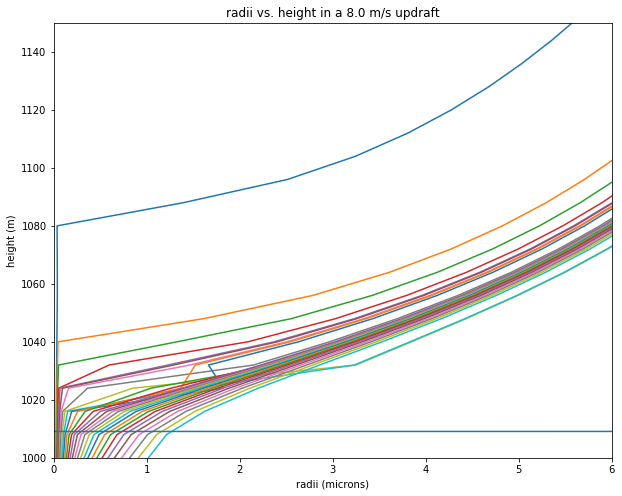

In [21]:
fig, ax = plt.subplots(1,1,figsize=[10,8])
for i in colnames[:-3]:
    ax.plot(df_output[i]*1.e6,df_output['z'],label=i)
    out=ax.set(ylim=[1000,1150],xlim=[0,6],
               xlabel='radii (microns)',ylabel='height (m)',
               title= f'radii vs. height in a {cloud_tup.wvel} m/s updraft')

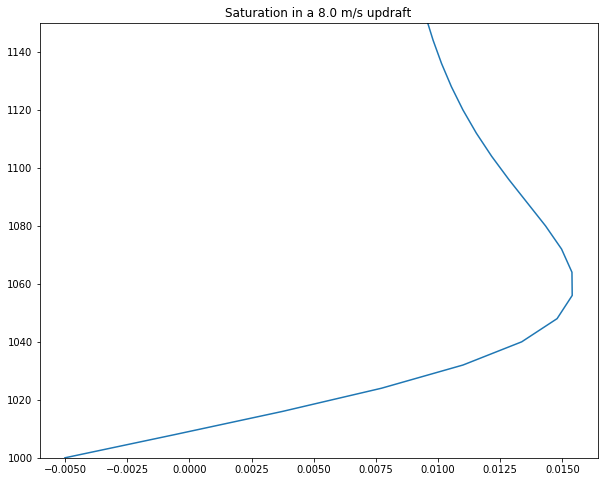

In [22]:
fig, ax = plt.subplots(1,1,figsize=[10,8])
ax.plot('SS','z',data=df_output)
out=ax.set(ylim=[1000,1150],title=f'Saturation in a {cloud_tup.wvel} m/s updraft')